In [1]:
from google.colab import files
uploaded = files.upload()

Saving Accident_Prediction_Dataset.csv to Accident_Prediction_Dataset (1).csv


In [2]:
# Install required libraries
!pip install pandas scikit-learn xgboost catboost shap matplotlib seaborn imblearn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import libraries
import pandas as pd

In [5]:
# Load the dataset
df = pd.read_csv('Accident_Prediction_Dataset.csv')

# Display basic info
print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())
print("\nColumn Names:")
print(list(df.columns))
print("\nAccident Severity Distribution:")
print(df['Accident_severity'].value_counts(normalize=True) * 100)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_allignment  


Weather Conditions Distribution (%):
Weather_conditions
Normal               81.706723
Raining              10.807080
Other                 2.403378
Unknown               2.370900
Cloudy                1.014940
Windy                 0.795713
Snow                  0.495291
Raining and Windy     0.324781
Fog or mist           0.081195
Name: proportion, dtype: float64

Age Band of Driver Distribution (%):
Age_band_of_driver
18-30       34.678467
31-50       33.184475
Over 51     12.869438
Unknown     12.569016
Under 18     6.698603
Name: proportion, dtype: float64


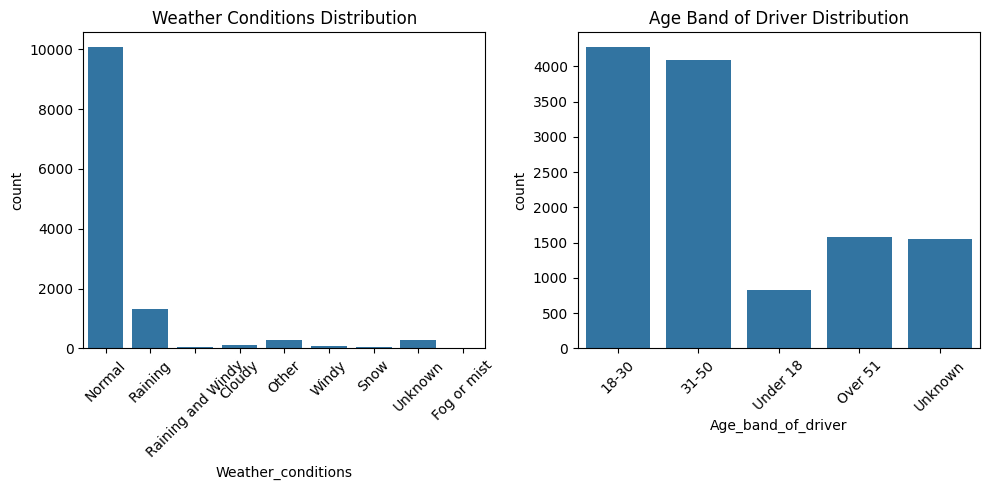


Missing Values (%):
Educational_level           6.016564
Vehicle_driver_relation     4.701202
Driving_experience          6.731082
Type_of_vehicle             7.713543
Owner_of_vehicle            3.913608
Service_year_of_vehicle    31.893472
Defect_of_vehicle          35.945112
Area_accident_occured       1.940565
Lanes_or_Medians            3.126015
Road_allignment             1.152972
Types_of_Junction           7.202014
Road_surface_type           1.396557
Type_of_collision           1.258525
Vehicle_movement            2.500812
Work_of_casuality          25.966223
Fitness_of_casuality       21.394933
dtype: float64

Cross-tabulation (Weather vs. Severity, %):
Accident_severity   Fatal injury  Serious Injury  Slight Injury
Weather_conditions                                             
Cloudy                  0.000000        6.400000      93.600000
Fog or mist             0.000000       10.000000      90.000000
Normal                  1.341548       14.647719      84.010732
Other  

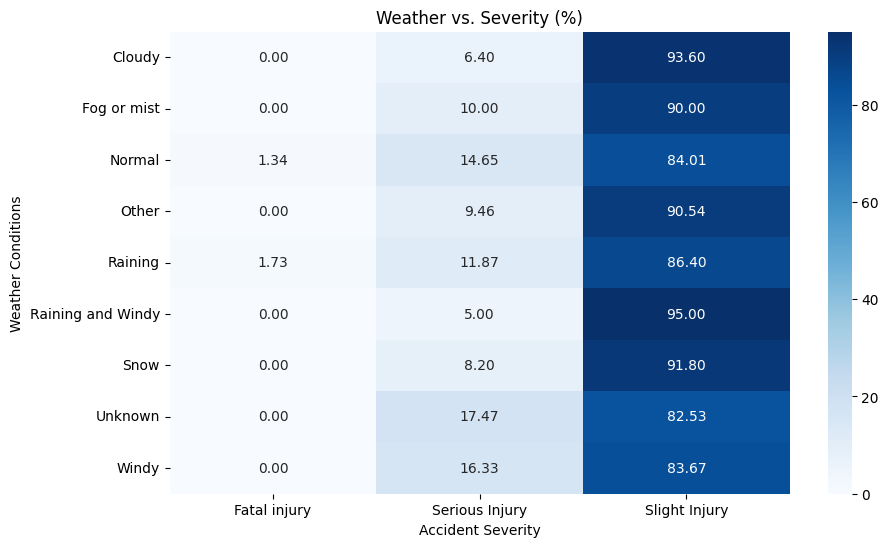

In [6]:
# Import libraries for EDA and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 1. Check Feature Distributions
print("\nWeather Conditions Distribution (%):")
print(df['Weather_conditions'].value_counts(normalize=True) * 100)
print("\nAge Band of Driver Distribution (%):")
print(df['Age_band_of_driver'].value_counts(normalize=True) * 100)

# Visualize distributions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='Weather_conditions', data=df)
plt.title('Weather Conditions Distribution')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
sns.countplot(x='Age_band_of_driver', data=df)
plt.title('Age Band of Driver Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Quantify Missing Values
print("\nMissing Values (%):")
missing_percent = df.isnull().mean() * 100
print(missing_percent[missing_percent > 0])  # Show only columns with missing values

# 3. Analyze Relationships (Cross-tabulation: Weather vs. Severity)
print("\nCross-tabulation (Weather vs. Severity, %):")
weather_severity = pd.crosstab(df['Weather_conditions'], df['Accident_severity'], normalize='index') * 100
print(weather_severity)

# Visualize cross-tabulation
plt.figure(figsize=(10, 6))
sns.heatmap(weather_severity, annot=True, fmt='.2f', cmap='Blues')
plt.title('Weather vs. Severity (%)')
plt.xlabel('Accident Severity')
plt.ylabel('Weather Conditions')
plt.show()


In [7]:
# Drop columns with high missingness (>30%)
columns_to_drop = ['Defect_of_vehicle', 'Service_year_of_vehicle']
df_clean = df.drop(columns=columns_to_drop)

# Display results
print("\nColumns Dropped:")
print(columns_to_drop)
print("\nRemaining Columns:")
print(list(df_clean.columns))
print("\nNumber of Columns Remaining:")
print(len(df_clean.columns))
print("\nDataset Shape After Dropping Columns:")
print(df_clean.shape)


Columns Dropped:
['Defect_of_vehicle', 'Service_year_of_vehicle']

Remaining Columns:
['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level', 'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment', 'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions', 'Light_conditions', 'Weather_conditions', 'Type_of_collision', 'Number_of_vehicles_involved', 'Number_of_casualties', 'Vehicle_movement', 'Casualty_class', 'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity', 'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement', 'Cause_of_accident', 'Accident_severity']

Number of Columns Remaining:
30

Dataset Shape After Dropping Columns:
(12316, 30)


In [8]:
# List columns to impute (based on missing values <7% from your output)
impute_columns = ['Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
                  'Type_of_vehicle', 'Owner_of_vehicle', 'Area_accident_occured',
                  'Lanes_or_Medians', 'Road_allignment', 'Types_of_Junction',
                  'Road_surface_type', 'Type_of_collision', 'Vehicle_movement',
                  'Work_of_casuality', 'Fitness_of_casuality']

# Impute missing values with the most common value (mode)
for col in impute_columns:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

# Display results
print("\nMissing Values After Imputation (%):")
missing_percent = df_clean.isnull().mean() * 100
print(missing_percent)

# Show the most common value used for imputation in key columns
print("\nMost Common Values Used for Imputation:")
for col in ['Driving_experience', 'Educational_level', 'Work_of_casuality']:
    print(f"{col}: {df_clean[col].mode()[0]}")


Missing Values After Imputation (%):
Time                           0.0
Day_of_week                    0.0
Age_band_of_driver             0.0
Sex_of_driver                  0.0
Educational_level              0.0
Vehicle_driver_relation        0.0
Driving_experience             0.0
Type_of_vehicle                0.0
Owner_of_vehicle               0.0
Area_accident_occured          0.0
Lanes_or_Medians               0.0
Road_allignment                0.0
Types_of_Junction              0.0
Road_surface_type              0.0
Road_surface_conditions        0.0
Light_conditions               0.0
Weather_conditions             0.0
Type_of_collision              0.0
Number_of_vehicles_involved    0.0
Number_of_casualties           0.0
Vehicle_movement               0.0
Casualty_class                 0.0
Sex_of_casualty                0.0
Age_band_of_casualty           0.0
Casualty_severity              0.0
Work_of_casuality              0.0
Fitness_of_casuality           0.0
Pedestrian_moveme

In [9]:
from sklearn.preprocessing import LabelEncoder
# Define categorical and ordinal columns (ensuring all are included)
categorical_cols = ['Weather_conditions', 'Road_surface_type', 'Road_surface_conditions',
                   'Day_of_week', 'Type_of_vehicle', 'Owner_of_vehicle',
                   'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
                   'Types_of_Junction', 'Type_of_collision', 'Vehicle_movement',
                   'Cause_of_accident', 'Light_conditions', 'Sex_of_driver',
                   'Casualty_class', 'Sex_of_casualty', 'Work_of_casuality',
                   'Fitness_of_casuality', 'Pedestrian_movement', 'Vehicle_driver_relation']
ordinal_cols = ['Age_band_of_driver', 'Educational_level', 'Driving_experience',
                'Age_band_of_casualty', 'Casualty_severity']

# 1. One-hot encode categorical features
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, prefix_sep='_')

# 2. Numerically encode ordinal features
le = LabelEncoder()
for col in ordinal_cols:
    df_encoded[col] = le.fit_transform(df_clean[col])

# Display results
print("\nEncoded Columns (First 5 Rows):")
print(df_encoded.head())
print("\nEncoded Column Names:")
print(list(df_encoded.columns))
print("\nNumber of Columns After Encoding:")
print(len(df_encoded.columns))
print("\nSample of Encoded Ordinal Features (First 5 Rows):")
for col in ordinal_cols:
    print(f"{col}:\n{df_encoded[col].head()}")
print("\nSample of Encoded Categorical Features (First 5 Rows, Selected Columns):")
sample_categorical = [col for col in df_encoded.columns if col.startswith(('Weather_conditions_', 'Vehicle_driver_relation_'))][:6]
for col in sample_categorical:
    print(f"{col}:\n{df_encoded[col].head()}")


Encoded Columns (First 5 Rows):
       Time  Age_band_of_driver  Educational_level  Driving_experience  \
0  17:02:00                   0                  0                   0   
1  17:02:00                   1                  4                   3   
2  17:02:00                   0                  4                   0   
3  01:06:00                   0                  4                   2   
4  01:06:00                   0                  4                   1   

   Number_of_vehicles_involved  Number_of_casualties  Age_band_of_casualty  \
0                            2                     2                     5   
1                            2                     2                     5   
2                            2                     2                     1   
3                            2                     2                     0   
4                            2                     2                     5   

   Casualty_severity Accident_severity  Weather_condi

In [10]:
# Import sklearn
from sklearn.preprocessing import MinMaxScaler

# Define numerical columns
numerical_cols = ['Number_of_vehicles_involved', 'Number_of_casualties']

# Normalize numerical features
scaler = MinMaxScaler()  # Normalization to [0,1]
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# Display results
print("\nScaled Numerical Features (First 5 Rows):")
print(df_encoded[numerical_cols].head())
print("\nSummary Statistics of Scaled Numerical Features:")
print(df_encoded[numerical_cols].describe())



Scaled Numerical Features (First 5 Rows):
   Number_of_vehicles_involved  Number_of_casualties
0                     0.166667              0.142857
1                     0.166667              0.142857
2                     0.166667              0.142857
3                     0.166667              0.142857
4                     0.166667              0.142857

Summary Statistics of Scaled Numerical Features:
       Number_of_vehicles_involved  Number_of_casualties
count                 12316.000000          12316.000000
mean                      0.173446              0.078307
std                       0.114798              0.143883
min                       0.000000              0.000000
25%                       0.166667              0.000000
50%                       0.166667              0.000000
75%                       0.166667              0.142857
max                       1.000000              1.000000


In [11]:
# Import imblearn
from imblearn.over_sampling import SMOTE

# Prepare features (X) and target (y), dropping 'Time' and 'Accident_severity'
X = df_encoded.drop(['Accident_severity', 'Time'], axis=1)
y = df_encoded['Accident_severity']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Display results
print("\nClass Distribution After SMOTE (%):")
print(pd.Series(y_res).value_counts(normalize=True) * 100)
print("\nDataset Shape After SMOTE:")
print(X_res.shape)
print("\nFirst 5 Rows of Resampled Features (Selected Columns):")
# Select a few columns for display (numerical and some dummy variables)
sample_cols = ['Number_of_vehicles_involved', 'Number_of_casualties',
               'Weather_conditions_Normal', 'Vehicle_driver_relation_Employee']
print(X_res[sample_cols].head())


Class Distribution After SMOTE (%):
Accident_severity
Slight Injury     33.333333
Serious Injury    33.333333
Fatal injury      33.333333
Name: proportion, dtype: float64

Dataset Shape After SMOTE:
(31245, 173)

First 5 Rows of Resampled Features (Selected Columns):
   Number_of_vehicles_involved  Number_of_casualties  \
0                     0.166667              0.142857   
1                     0.166667              0.142857   
2                     0.166667              0.142857   
3                     0.166667              0.142857   
4                     0.166667              0.142857   

   Weather_conditions_Normal  Vehicle_driver_relation_Employee  
0                       True                              True  
1                       True                              True  
2                       True                              True  
3                       True                              True  
4                       True                              True  



Mutual Information Scores (Top 15):
Number_of_casualties                              0.246086
Number_of_vehicles_involved                       0.161440
Day_of_week_Sunday                                0.038702
Types_of_Junction_No junction                     0.038184
Driving_experience                                0.036180
Light_conditions_Darkness - lights lit            0.035329
Lanes_or_Medians_Undivided Two way                0.034698
Road_allignment_Tangent road with flat terrain    0.030094
Cause_of_accident_Moving Backward                 0.027611
Age_band_of_driver                                0.026137
Work_of_casuality_Driver                          0.026064
Sex_of_driver_Male                                0.022423
Area_accident_occured_Other                       0.019154
Age_band_of_casualty                              0.017568
Type_of_vehicle_Automobile                        0.016863
dtype: float64

Final Selected Features:
['Number_of_casualties', 'Number_of_v

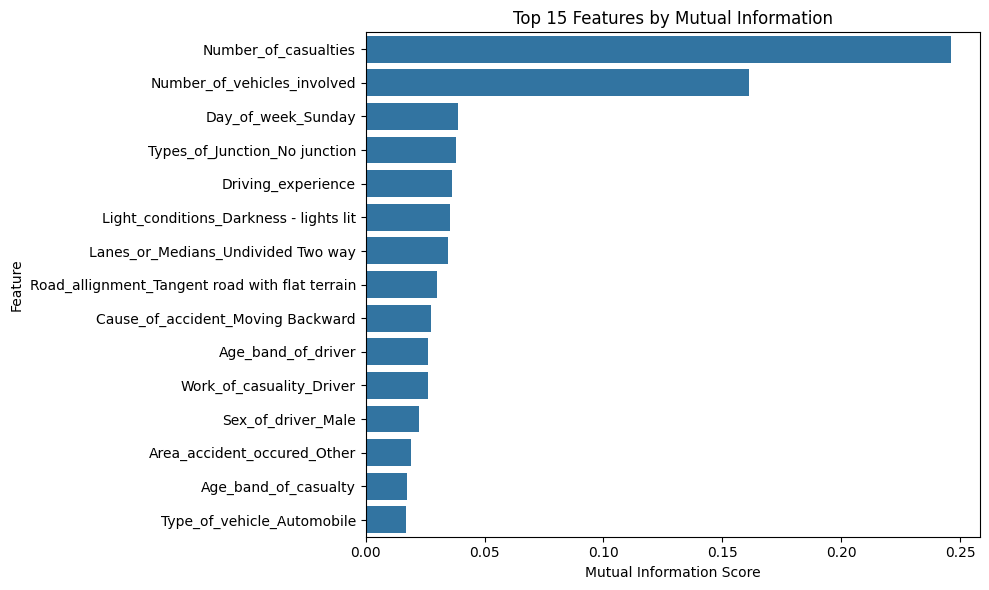

In [12]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate mutual information scores
mi_scores = mutual_info_classif(X_res, y_res, discrete_features='auto')

# Create a Series for easy sorting
mi_series = pd.Series(mi_scores, index=X_res.columns).sort_values(ascending=False)

# Select top 15 features
selected_features = mi_series.head(15).index.tolist()

# Display
print("\nMutual Information Scores (Top 15):")
print(mi_series.head(15))
print("\nFinal Selected Features:")
print(selected_features)

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x=mi_series.head(15).values, y=mi_series.head(15).index)
plt.title('Top 15 Features by Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [13]:
from google.colab import drive

# Create a DataFrame with selected features and target
df_preprocessed = X_res[selected_features].copy()
df_preprocessed['Accident_severity'] = y_res

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Save the preprocessed dataset to Google Drive
save_path = '/content/drive/MyDrive/Accident_Prediction_Preprocessed.csv'
df_preprocessed.to_csv(save_path, index=False)
print("\nPreprocessed Dataset Saved to:")
print(save_path)

# Load the saved dataset to verify
df_loaded = pd.read_csv(save_path)

# Display verification results
print("\nLoaded Dataset Shape:")
print(df_loaded.shape)
print("\nLoaded Dataset Columns:")
print(list(df_loaded.columns))
print("\nFirst 5 Rows of Loaded Dataset (Selected Columns):")
# Select a few columns for display
sample_cols = ['Number_of_casualties', 'Number_of_vehicles_involved', 'Driving_experience', 'Accident_severity']
print(df_loaded[sample_cols].head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Preprocessed Dataset Saved to:
/content/drive/MyDrive/Accident_Prediction_Preprocessed.csv

Loaded Dataset Shape:
(31245, 16)

Loaded Dataset Columns:
['Number_of_casualties', 'Number_of_vehicles_involved', 'Day_of_week_Sunday', 'Types_of_Junction_No junction', 'Driving_experience', 'Light_conditions_Darkness - lights lit', 'Lanes_or_Medians_Undivided Two way', 'Road_allignment_Tangent road with flat terrain', 'Cause_of_accident_Moving Backward', 'Age_band_of_driver', 'Work_of_casuality_Driver', 'Sex_of_driver_Male', 'Area_accident_occured_Other', 'Age_band_of_casualty', 'Type_of_vehicle_Automobile', 'Accident_severity']

First 5 Rows of Loaded Dataset (Selected Columns):
   Number_of_casualties  Number_of_vehicles_involved  Driving_experience  \
0              0.142857                     0.166667                   0   
1              0.142857              

In [14]:
# Import libraries (already installed)
from sklearn.model_selection import train_test_split
import pandas as pd
from google.colab import drive

# Load the preprocessed dataset
save_path = '/content/drive/MyDrive/Accident_Prediction_Preprocessed.csv'
df_preprocessed = pd.read_csv(save_path)

# Prepare features (X) and target (y)
X = df_preprocessed.drop('Accident_severity', axis=1)  # 15 features
y = df_preprocessed['Accident_severity']

# Split into 80% train and 20% remaining (test + validation), with stratification
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the 20% into 50% test and 50% validation, with stratification
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Check split sizes
print("\nDataset Split Sizes:")
print(f"Training Set Size: {X_train.shape[0]} ({100 * X_train.shape[0] / X.shape[0]:.2f}%)")
print(f"Validation Set Size: {X_val.shape[0]} ({100 * X_val.shape[0] / X.shape[0]:.2f}%)")
print(f"Test Set Size: {X_test.shape[0]} ({100 * X_test.shape[0] / X.shape[0]:.2f}%)")

# Check class distribution in each set
print("\nClass Distribution in Training Set (%):")
print(pd.Series(y_train).value_counts(normalize=True) * 100)
print("\nClass Distribution in Validation Set (%):")
print(pd.Series(y_val).value_counts(normalize=True) * 100)
print("\nClass Distribution in Test Set (%):")
print(pd.Series(y_test).value_counts(normalize=True) * 100)

# Verify number of features
print("\nNumber of Features in X_train:", X_train.shape[1])
print("Feature Names:", list(X_train.columns))


Dataset Split Sizes:
Training Set Size: 24996 (80.00%)
Validation Set Size: 3125 (10.00%)
Test Set Size: 3124 (10.00%)

Class Distribution in Training Set (%):
Accident_severity
Serious Injury    33.333333
Fatal injury      33.333333
Slight Injury     33.333333
Name: proportion, dtype: float64

Class Distribution in Validation Set (%):
Accident_severity
Serious Injury    33.344
Slight Injury     33.344
Fatal injury      33.312
Name: proportion, dtype: float64

Class Distribution in Test Set (%):
Accident_severity
Fatal injury      33.354673
Serious Injury    33.322663
Slight Injury     33.322663
Name: proportion, dtype: float64

Number of Features in X_train: 15
Feature Names: ['Number_of_casualties', 'Number_of_vehicles_involved', 'Day_of_week_Sunday', 'Types_of_Junction_No junction', 'Driving_experience', 'Light_conditions_Darkness - lights lit', 'Lanes_or_Medians_Undivided Two way', 'Road_allignment_Tangent road with flat terrain', 'Cause_of_accident_Moving Backward', 'Age_band_of_

In [15]:
# Import libraries
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Initialize CatBoost with baseline parameters
catboost_model = CatBoostClassifier(n_estimators=100, random_state=42, verbose=0)

# Train the model
catboost_model.fit(X_train, y_train)

# Predict on validation set
y_pred = catboost_model.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# Display results
print("\nBaseline CatBoost Performance on Validation Set (15 Features):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Baseline CatBoost Performance on Validation Set (15 Features):
Accuracy: 0.8368
Precision: 0.8385
Recall: 0.8368
F1-Score: 0.8335


In [16]:
# Import libraries
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Define parameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'iterations': [100, 200, 300]
}

# Initialize CatBoost
catboost_model = CatBoostClassifier(random_state=42, verbose=0)

# Perform grid search
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid,
                           scoring='f1_weighted', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on validation set with tuned model
y_pred_tuned = best_model.predict(X_val)

# Calculate metrics
accuracy_tuned = accuracy_score(y_val, y_pred_tuned)
precision_tuned = precision_score(y_val, y_pred_tuned, average='weighted')
recall_tuned = recall_score(y_val, y_pred_tuned, average='weighted')
f1_tuned = f1_score(y_val, y_pred_tuned, average='weighted')

# Display results
print("\nBest Hyperparameters from Grid Search:")
print(best_params)
print("\nTuned CatBoost Performance on Validation Set (15 Features):")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1-Score: {f1_tuned:.4f}")


Best Hyperparameters from Grid Search:
{'depth': 8, 'iterations': 300, 'learning_rate': 0.2}

Tuned CatBoost Performance on Validation Set (15 Features):
Accuracy: 0.8790
Precision: 0.8806
Recall: 0.8790
F1-Score: 0.8775



Tuned CatBoost Performance on Validation Set (Recap):
Accuracy: 0.8790
Precision: 0.8806
Recall: 0.8790
F1-Score: 0.8775

Confusion Matrix:
[[1027    4   10]
 [  43  791  208]
 [  12  101  929]]

Confusion Matrix (Labeled):
Classes: ['Fatal injury' 'Serious Injury' 'Slight Injury']
                Fatal injury  Serious Injury  Slight Injury
Fatal injury            1027               4             10
Serious Injury            43             791            208
Slight Injury             12             101            929

Feature Importance Scores:
Number_of_casualties                              16.341733
Number_of_vehicles_involved                       14.742424
Age_band_of_casualty                              11.646557
Age_band_of_driver                                 9.150250
Driving_experience                                 8.501336
Light_conditions_Darkness - lights lit             6.451020
Lanes_or_Medians_Undivided Two way                 6.178909
Types_of_Junction_No junctio

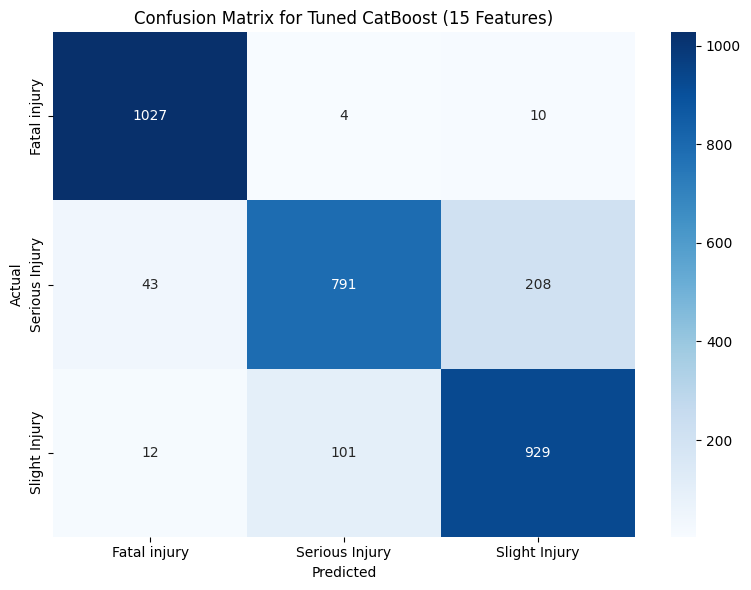


Text Summary of Confusion Matrix:
Actual Fatal injury, Predicted Fatal injury: 1027
Actual Fatal injury, Predicted Serious Injury: 4
Actual Fatal injury, Predicted Slight Injury: 10
Actual Serious Injury, Predicted Fatal injury: 43
Actual Serious Injury, Predicted Serious Injury: 791
Actual Serious Injury, Predicted Slight Injury: 208
Actual Slight Injury, Predicted Fatal injury: 12
Actual Slight Injury, Predicted Serious Injury: 101
Actual Slight Injury, Predicted Slight Injury: 929


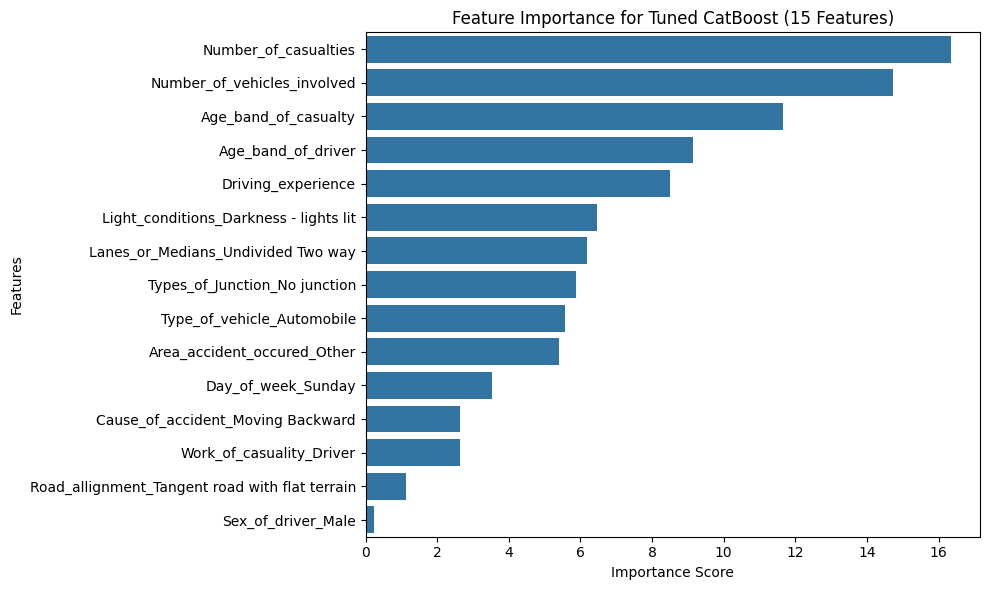


Text Summary of Feature Importance Plot:
Number_of_casualties: 16.3417
Number_of_vehicles_involved: 14.7424
Age_band_of_casualty: 11.6466
Age_band_of_driver: 9.1502
Driving_experience: 8.5013
Light_conditions_Darkness - lights lit: 6.4510
Lanes_or_Medians_Undivided Two way: 6.1789
Types_of_Junction_No junction: 5.8826
Type_of_vehicle_Automobile: 5.5591
Area_accident_occured_Other: 5.3879
Day_of_week_Sunday: 3.5244
Cause_of_accident_Moving Backward: 2.6471
Work_of_casuality_Driver: 2.6280
Road_allignment_Tangent road with flat terrain: 1.1133
Sex_of_driver_Male: 0.2453


In [17]:
# Import libraries
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize and train tuned CatBoost model
tuned_catboost = CatBoostClassifier(depth=8, iterations=300, learning_rate=0.2, random_state=42, verbose=0)
tuned_catboost.fit(X_train, y_train)

# Predict on validation set
y_pred_tuned = tuned_catboost.predict(X_val)

# Calculate metrics (for reference)
accuracy = accuracy_score(y_val, y_pred_tuned)
precision = precision_score(y_val, y_pred_tuned, average='weighted')
recall = recall_score(y_val, y_pred_tuned, average='weighted')
f1 = f1_score(y_val, y_pred_tuned, average='weighted')

# Get confusion matrix
cm = confusion_matrix(y_val, y_pred_tuned, labels=tuned_catboost.classes_)

# Get feature importance
feature_importance = pd.Series(tuned_catboost.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Display results
print("\nTuned CatBoost Performance on Validation Set (Recap):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nConfusion Matrix:")
print(cm)
print("\nConfusion Matrix (Labeled):")
print(f"Classes: {tuned_catboost.classes_}")
print(pd.DataFrame(cm, index=tuned_catboost.classes_, columns=tuned_catboost.classes_))

print("\nFeature Importance Scores:")
print(feature_importance)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tuned_catboost.classes_, yticklabels=tuned_catboost.classes_)
plt.title('Confusion Matrix for Tuned CatBoost (15 Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Text summary of confusion matrix
print("\nText Summary of Confusion Matrix:")
for i, actual in enumerate(tuned_catboost.classes_):
    for j, predicted in enumerate(tuned_catboost.classes_):
        print(f"Actual {actual}, Predicted {predicted}: {cm[i, j]}")

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Feature Importance for Tuned CatBoost (15 Features)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Text summary of feature importance
print("\nText Summary of Feature Importance Plot:")
for feature, importance in feature_importance.items():
    print(f"{feature}: {importance:.4f}")


Tuned CatBoost Performance on Test Set (15 Features):
Accuracy: 0.8745
Precision: 0.8745
Recall: 0.8745
F1-Score: 0.8735

Confusion Matrix (Test Set):
[[1034    1    7]
 [  27  805  209]
 [  10  138  893]]

Confusion Matrix (Labeled, Test Set):
Classes: ['Fatal injury' 'Serious Injury' 'Slight Injury']
                Fatal injury  Serious Injury  Slight Injury
Fatal injury            1034               1              7
Serious Injury            27             805            209
Slight Injury             10             138            893


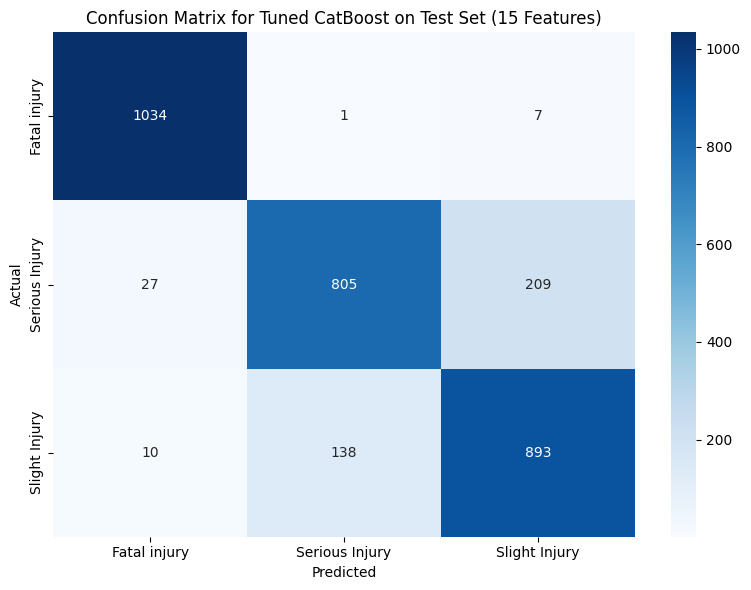


Text Summary of Confusion Matrix (Test Set):
Actual Fatal injury, Predicted Fatal injury: 1034
Actual Fatal injury, Predicted Serious Injury: 1
Actual Fatal injury, Predicted Slight Injury: 7
Actual Serious Injury, Predicted Fatal injury: 27
Actual Serious Injury, Predicted Serious Injury: 805
Actual Serious Injury, Predicted Slight Injury: 209
Actual Slight Injury, Predicted Fatal injury: 10
Actual Slight Injury, Predicted Serious Injury: 138
Actual Slight Injury, Predicted Slight Injury: 893


In [18]:
# Import libraries
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize and train tuned CatBoost model (using training data)
tuned_catboost = CatBoostClassifier(depth=8, iterations=300, learning_rate=0.2, random_state=42, verbose=0)
tuned_catboost.fit(X_train, y_train)

# Predict on test set
y_pred_test = tuned_catboost.predict(X_test)

# Calculate metrics
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

# Get confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test, labels=tuned_catboost.classes_)

# Display results
print("\nTuned CatBoost Performance on Test Set (15 Features):")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")

print("\nConfusion Matrix (Test Set):")
print(cm_test)
print("\nConfusion Matrix (Labeled, Test Set):")
print(f"Classes: {tuned_catboost.classes_}")
print(pd.DataFrame(cm_test, index=tuned_catboost.classes_, columns=tuned_catboost.classes_))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=tuned_catboost.classes_, yticklabels=tuned_catboost.classes_)
plt.title('Confusion Matrix for Tuned CatBoost on Test Set (15 Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Text summary of confusion matrix
print("\nText Summary of Confusion Matrix (Test Set):")
for i, actual in enumerate(tuned_catboost.classes_):
    for j, predicted in enumerate(tuned_catboost.classes_):
        print(f"Actual {actual}, Predicted {predicted}: {cm_test[i, j]}")

In [19]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Initialize Random Forest with baseline parameters
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on validation set
y_pred_rf = rf_model.predict(X_val)

# Calculate metrics
accuracy_rf = accuracy_score(y_val, y_pred_rf)
precision_rf = precision_score(y_val, y_pred_rf, average='weighted')
recall_rf = recall_score(y_val, y_pred_rf, average='weighted')
f1_rf = f1_score(y_val, y_pred_rf, average='weighted')

# Display results
print("\nBaseline Random Forest Performance on Validation Set (15 Features):")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")


Baseline Random Forest Performance on Validation Set (15 Features):
Accuracy: 0.8883
Precision: 0.8879
Recall: 0.8883
F1-Score: 0.8878


In [20]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Initialize Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           scoring='f1_weighted', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on validation set with tuned model
y_pred_tuned = best_model.predict(X_val)

# Calculate metrics
accuracy_tuned = accuracy_score(y_val, y_pred_tuned)
precision_tuned = precision_score(y_val, y_pred_tuned, average='weighted')
recall_tuned = recall_score(y_val, y_pred_tuned, average='weighted')
f1_tuned = f1_score(y_val, y_pred_tuned, average='weighted')

# Display results
print("\nBest Hyperparameters from Grid Search (Random Forest):")
print(best_params)
print("\nTuned Random Forest Performance on Validation Set (15 Features):")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1-Score: {f1_tuned:.4f}")


Best Hyperparameters from Grid Search (Random Forest):
{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}

Tuned Random Forest Performance on Validation Set (15 Features):
Accuracy: 0.8870
Precision: 0.8878
Recall: 0.8870
F1-Score: 0.8863



Tuned Random Forest Performance on Validation Set (Recap):
Accuracy: 0.8883
Precision: 0.8880
Recall: 0.8883
F1-Score: 0.8877

Confusion Matrix:
[[1025    6   10]
 [  30  843  169]
 [   9  125  908]]

Confusion Matrix (Labeled):
Classes: ['Fatal injury' 'Serious Injury' 'Slight Injury']
                Fatal injury  Serious Injury  Slight Injury
Fatal injury            1025               6             10
Serious Injury            30             843            169
Slight Injury              9             125            908

Feature Importance Scores:
Number_of_casualties                              0.186301
Number_of_vehicles_involved                       0.161670
Driving_experience                                0.108717
Age_band_of_driver                                0.105256
Age_band_of_casualty                              0.101320
Light_conditions_Darkness - lights lit            0.044152
Day_of_week_Sunday                                0.040842
Lanes_or_Medians_Undivided Two

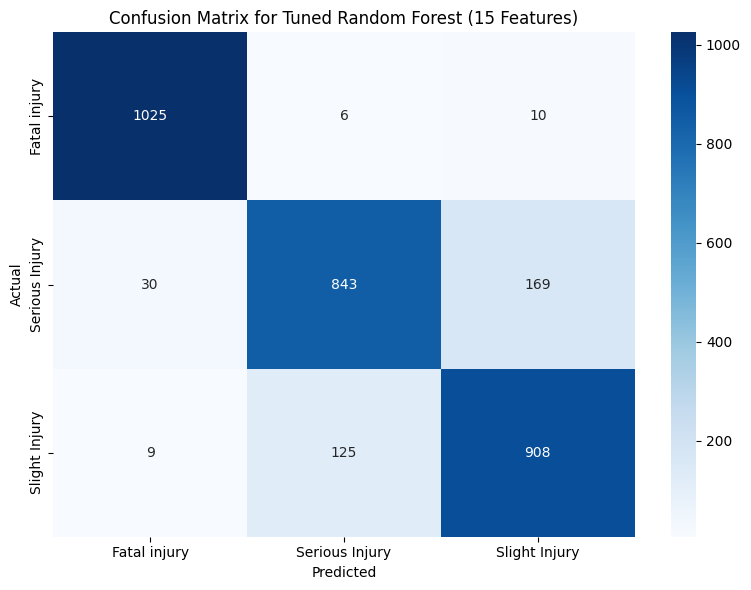


Text Summary of Confusion Matrix:
Actual Fatal injury, Predicted Fatal injury: 1025
Actual Fatal injury, Predicted Serious Injury: 6
Actual Fatal injury, Predicted Slight Injury: 10
Actual Serious Injury, Predicted Fatal injury: 30
Actual Serious Injury, Predicted Serious Injury: 843
Actual Serious Injury, Predicted Slight Injury: 169
Actual Slight Injury, Predicted Fatal injury: 9
Actual Slight Injury, Predicted Serious Injury: 125
Actual Slight Injury, Predicted Slight Injury: 908


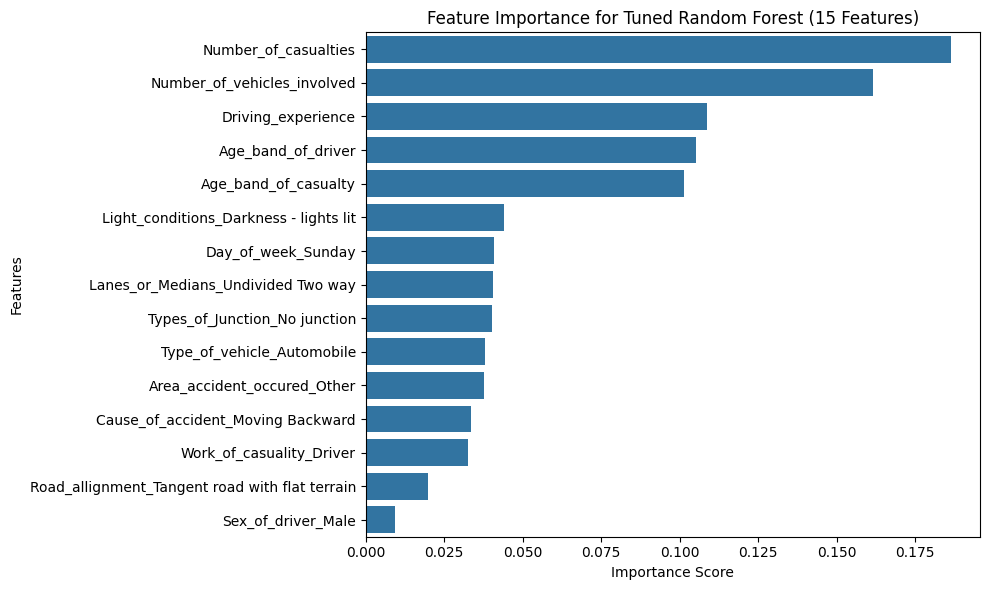


Text Summary of Feature Importance Plot:
Number_of_casualties: 0.1863
Number_of_vehicles_involved: 0.1617
Driving_experience: 0.1087
Age_band_of_driver: 0.1053
Age_band_of_casualty: 0.1013
Light_conditions_Darkness - lights lit: 0.0442
Day_of_week_Sunday: 0.0408
Lanes_or_Medians_Undivided Two way: 0.0405
Types_of_Junction_No junction: 0.0404
Type_of_vehicle_Automobile: 0.0380
Area_accident_occured_Other: 0.0377
Cause_of_accident_Moving Backward: 0.0336
Work_of_casuality_Driver: 0.0324
Road_allignment_Tangent road with flat terrain: 0.0199
Sex_of_driver_Male: 0.0092


In [21]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize and train tuned Random Forest model
tuned_rf = RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=300, random_state=42)
tuned_rf.fit(X_train, y_train)

# Predict on validation set
y_pred_tuned = tuned_rf.predict(X_val)

# Calculate metrics (for reference)
accuracy = accuracy_score(y_val, y_pred_tuned)
precision = precision_score(y_val, y_pred_tuned, average='weighted')
recall = recall_score(y_val, y_pred_tuned, average='weighted')
f1 = f1_score(y_val, y_pred_tuned, average='weighted')

# Get confusion matrix
cm = confusion_matrix(y_val, y_pred_tuned, labels=tuned_rf.classes_)

# Get feature importance
feature_importance = pd.Series(tuned_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Display results
print("\nTuned Random Forest Performance on Validation Set (Recap):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nConfusion Matrix:")
print(cm)
print("\nConfusion Matrix (Labeled):")
print(f"Classes: {tuned_rf.classes_}")
print(pd.DataFrame(cm, index=tuned_rf.classes_, columns=tuned_rf.classes_))

print("\nFeature Importance Scores:")
print(feature_importance)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tuned_rf.classes_, yticklabels=tuned_rf.classes_)
plt.title('Confusion Matrix for Tuned Random Forest (15 Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Text summary of confusion matrix
print("\nText Summary of Confusion Matrix:")
for i, actual in enumerate(tuned_rf.classes_):
    for j, predicted in enumerate(tuned_rf.classes_):
        print(f"Actual {actual}, Predicted {predicted}: {cm[i, j]}")

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Feature Importance for Tuned Random Forest (15 Features)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Text summary of feature importance
print("\nText Summary of Feature Importance Plot:")
for feature, importance in feature_importance.items():
    print(f"{feature}: {importance:.4f}")


Tuned Random Forest Performance on Test Set (15 Features):
Accuracy: 0.8832
Precision: 0.8825
Recall: 0.8832
F1-Score: 0.8827

Confusion Matrix (Test Set):
[[1034    2    6]
 [  18  850  173]
 [   7  159  875]]

Confusion Matrix (Labeled, Test Set):
Classes: ['Fatal injury' 'Serious Injury' 'Slight Injury']
                Fatal injury  Serious Injury  Slight Injury
Fatal injury            1034               2              6
Serious Injury            18             850            173
Slight Injury              7             159            875


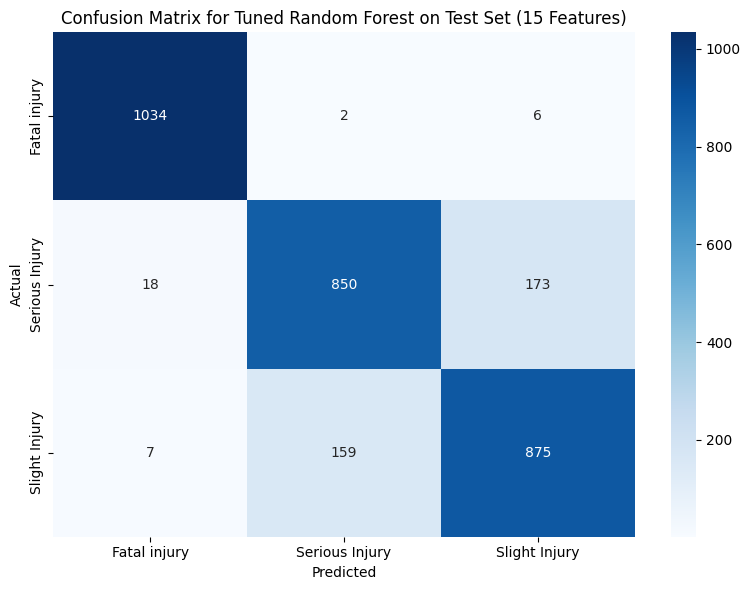


Text Summary of Confusion Matrix (Test Set):
Actual Fatal injury, Predicted Fatal injury: 1034
Actual Fatal injury, Predicted Serious Injury: 2
Actual Fatal injury, Predicted Slight Injury: 6
Actual Serious Injury, Predicted Fatal injury: 18
Actual Serious Injury, Predicted Serious Injury: 850
Actual Serious Injury, Predicted Slight Injury: 173
Actual Slight Injury, Predicted Fatal injury: 7
Actual Slight Injury, Predicted Serious Injury: 159
Actual Slight Injury, Predicted Slight Injury: 875


In [22]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize and train tuned Random Forest model
tuned_rf = RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=300, random_state=42)
tuned_rf.fit(X_train, y_train)

# Predict on test set
y_pred_test = tuned_rf.predict(X_test)

# Calculate metrics
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

# Get confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test, labels=tuned_rf.classes_)

# Display results
print("\nTuned Random Forest Performance on Test Set (15 Features):")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")

print("\nConfusion Matrix (Test Set):")
print(cm_test)
print("\nConfusion Matrix (Labeled, Test Set):")
print(f"Classes: {tuned_rf.classes_}")
print(pd.DataFrame(cm_test, index=tuned_rf.classes_, columns=tuned_rf.classes_))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=tuned_rf.classes_, yticklabels=tuned_rf.classes_)
plt.title('Confusion Matrix for Tuned Random Forest on Test Set (15 Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Text summary of confusion matrix
print("\nText Summary of Confusion Matrix (Test Set):")
for i, actual in enumerate(tuned_rf.classes_):
    for j, predicted in enumerate(tuned_rf.classes_):
        print(f"Actual {actual}, Predicted {predicted}: {cm_test[i, j]}")

In [23]:
# Import libraries
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# XGBoost requires numerical labels, so encode y_train and y_val
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Initialize XGBoost with baseline parameters
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Train the model
xgb_model.fit(X_train, y_train_encoded)

# Predict on validation set
y_pred_xgb = xgb_model.predict(X_val)
y_pred_xgb_labels = label_encoder.inverse_transform(y_pred_xgb)  # Convert back to original labels

# Calculate metrics
accuracy_xgb = accuracy_score(y_val, y_pred_xgb_labels)
precision_xgb = precision_score(y_val, y_pred_xgb_labels, average='weighted')
recall_xgb = recall_score(y_val, y_pred_xgb_labels, average='weighted')
f1_xgb = f1_score(y_val, y_pred_xgb_labels, average='weighted')

# Display results
print("\nBaseline XGBoost Performance on Validation Set (15 Features):")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-Score: {f1_xgb:.4f}")
print(f"Classes (Encoded): {list(label_encoder.classes_)}")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:49:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Baseline XGBoost Performance on Validation Set (15 Features):
Accuracy: 0.8528
Precision: 0.8558
Recall: 0.8528
F1-Score: 0.8506
Classes (Encoded): ['Fatal injury', 'Serious Injury', 'Slight Injury']


In [24]:
# Import libraries
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Encode labels for XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Define parameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 200, 300]
}

# Initialize XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='mlogloss')

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='f1_weighted', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train_encoded)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on validation set with tuned model
y_pred_tuned = best_model.predict(X_val)
y_pred_tuned_labels = label_encoder.inverse_transform(y_pred_tuned)  # Convert back to original labels

# Calculate metrics
accuracy_tuned = accuracy_score(y_val, y_pred_tuned_labels)
precision_tuned = precision_score(y_val, y_pred_tuned_labels, average='weighted')
recall_tuned = recall_score(y_val, y_pred_tuned_labels, average='weighted')
f1_tuned = f1_score(y_val, y_pred_tuned_labels, average='weighted')

# Display results
print("\nBest Hyperparameters from Grid Search (XGBoost):")
print(best_params)
print("\nTuned XGBoost Performance on Validation Set (15 Features):")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1-Score: {f1_tuned:.4f}")
print(f"Classes (Encoded): {list(label_encoder.classes_)}")


Best Hyperparameters from Grid Search (XGBoost):
{'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 300}

Tuned XGBoost Performance on Validation Set (15 Features):
Accuracy: 0.8806
Precision: 0.8800
Recall: 0.8806
F1-Score: 0.8797
Classes (Encoded): ['Fatal injury', 'Serious Injury', 'Slight Injury']



Tuned XGBoost Performance on Validation Set (Recap):
Accuracy: 0.8800
Precision: 0.8800
Recall: 0.8800
F1-Score: 0.8790

Confusion Matrix:
[[1019   10   12]
 [  43  816  183]
 [   9  118  915]]

Confusion Matrix (Labeled):
Classes: ['Fatal injury', 'Serious Injury', 'Slight Injury']
                Fatal injury  Serious Injury  Slight Injury
Fatal injury            1019              10             12
Serious Injury            43             816            183
Slight Injury              9             118            915

Feature Importance Scores:
Number_of_casualties                              0.164282
Number_of_vehicles_involved                       0.128560
Cause_of_accident_Moving Backward                 0.091227
Day_of_week_Sunday                                0.084709
Light_conditions_Darkness - lights lit            0.069687
Work_of_casuality_Driver                          0.062643
Road_allignment_Tangent road with flat terrain    0.062439
Age_band_of_driver                

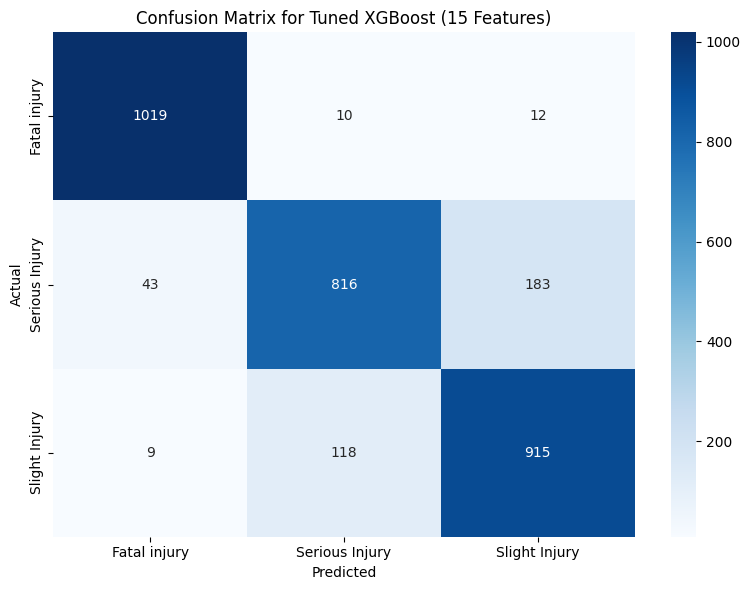


Text Summary of Confusion Matrix:
Actual Fatal injury, Predicted Fatal injury: 1019
Actual Fatal injury, Predicted Serious Injury: 10
Actual Fatal injury, Predicted Slight Injury: 12
Actual Serious Injury, Predicted Fatal injury: 43
Actual Serious Injury, Predicted Serious Injury: 816
Actual Serious Injury, Predicted Slight Injury: 183
Actual Slight Injury, Predicted Fatal injury: 9
Actual Slight Injury, Predicted Serious Injury: 118
Actual Slight Injury, Predicted Slight Injury: 915


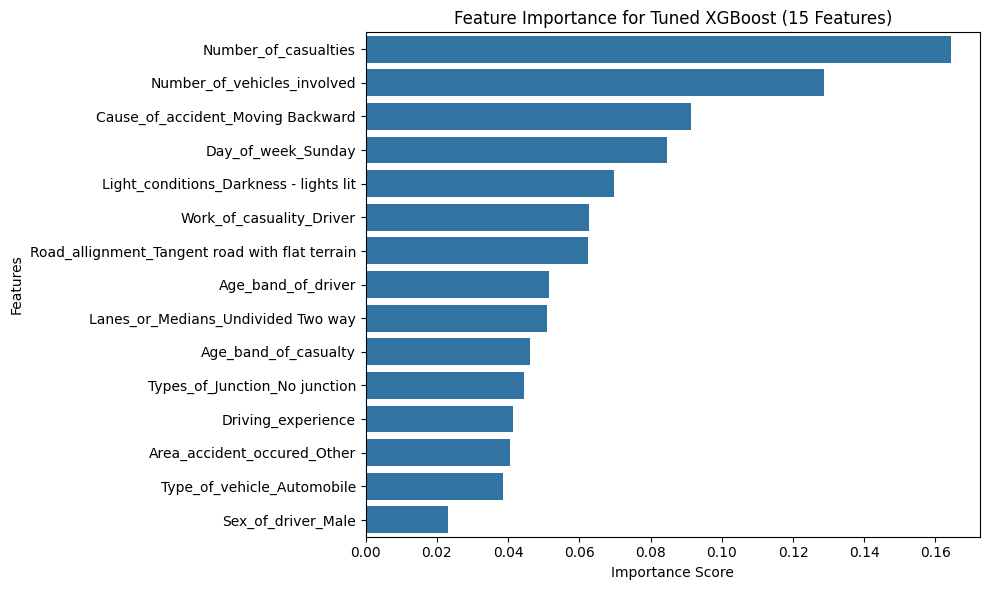


Text Summary of Feature Importance Plot:
Number_of_casualties: 0.1643
Number_of_vehicles_involved: 0.1286
Cause_of_accident_Moving Backward: 0.0912
Day_of_week_Sunday: 0.0847
Light_conditions_Darkness - lights lit: 0.0697
Work_of_casuality_Driver: 0.0626
Road_allignment_Tangent road with flat terrain: 0.0624
Age_band_of_driver: 0.0514
Lanes_or_Medians_Undivided Two way: 0.0510
Age_band_of_casualty: 0.0461
Types_of_Junction_No junction: 0.0445
Driving_experience: 0.0414
Area_accident_occured_Other: 0.0404
Type_of_vehicle_Automobile: 0.0385
Sex_of_driver_Male: 0.0231


In [25]:
# Import libraries
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Encode labels for XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Initialize and train tuned XGBoost model
tuned_xgb = XGBClassifier(learning_rate=0.2, max_depth=9, n_estimators=200, random_state=42, eval_metric='mlogloss')
tuned_xgb.fit(X_train, y_train_encoded)

# Predict on validation set
y_pred_tuned = tuned_xgb.predict(X_val)
y_pred_tuned_labels = label_encoder.inverse_transform(y_pred_tuned)  # Convert back to original labels

# Calculate metrics (for reference)
accuracy = accuracy_score(y_val, y_pred_tuned_labels)
precision = precision_score(y_val, y_pred_tuned_labels, average='weighted')
recall = recall_score(y_val, y_pred_tuned_labels, average='weighted')
f1 = f1_score(y_val, y_pred_tuned_labels, average='weighted')

# Get confusion matrix
cm = confusion_matrix(y_val, y_pred_tuned_labels, labels=label_encoder.classes_)

# Get feature importance
feature_importance = pd.Series(tuned_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Display results
print("\nTuned XGBoost Performance on Validation Set (Recap):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nConfusion Matrix:")
print(cm)
print("\nConfusion Matrix (Labeled):")
print(f"Classes: {list(label_encoder.classes_)}")
print(pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_))

print("\nFeature Importance Scores:")
print(feature_importance)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Tuned XGBoost (15 Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Text summary of confusion matrix
print("\nText Summary of Confusion Matrix:")
for i, actual in enumerate(label_encoder.classes_):
    for j, predicted in enumerate(label_encoder.classes_):
        print(f"Actual {actual}, Predicted {predicted}: {cm[i, j]}")

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Feature Importance for Tuned XGBoost (15 Features)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Text summary of feature importance
print("\nText Summary of Feature Importance Plot:")
for feature, importance in feature_importance.items():
    print(f"{feature}: {importance:.4f}")


Tuned XGBoost Performance on Test Set (15 Features):
Accuracy: 0.8707
Precision: 0.8701
Recall: 0.8707
F1-Score: 0.8698

Confusion Matrix (Test Set):
[[1026    8    8]
 [  31  811  199]
 [  12  146  883]]

Confusion Matrix (Labeled, Test Set):
Classes: ['Fatal injury', 'Serious Injury', 'Slight Injury']
                Fatal injury  Serious Injury  Slight Injury
Fatal injury            1026               8              8
Serious Injury            31             811            199
Slight Injury             12             146            883


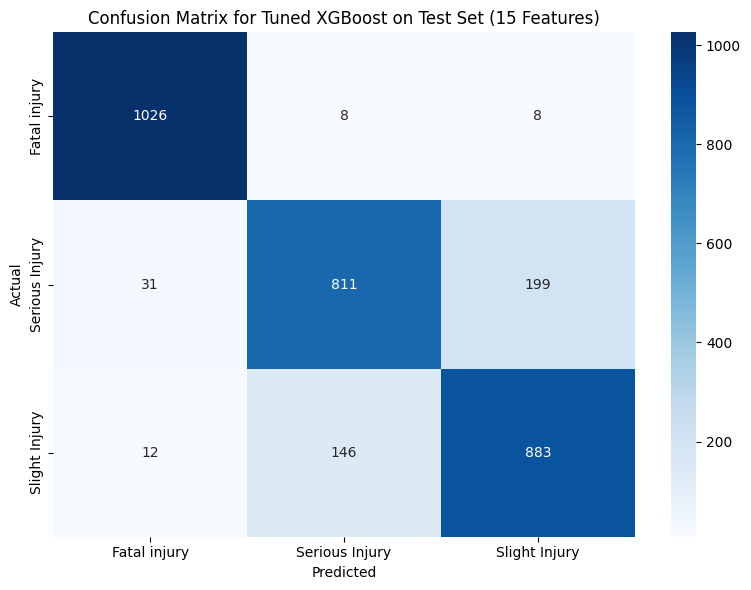


Text Summary of Confusion Matrix (Test Set):
Actual Fatal injury, Predicted Fatal injury: 1026
Actual Fatal injury, Predicted Serious Injury: 8
Actual Fatal injury, Predicted Slight Injury: 8
Actual Serious Injury, Predicted Fatal injury: 31
Actual Serious Injury, Predicted Serious Injury: 811
Actual Serious Injury, Predicted Slight Injury: 199
Actual Slight Injury, Predicted Fatal injury: 12
Actual Slight Injury, Predicted Serious Injury: 146
Actual Slight Injury, Predicted Slight Injury: 883


In [26]:
# Import libraries
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Encode labels for XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize and train tuned XGBoost model
tuned_xgb = XGBClassifier(learning_rate=0.2, max_depth=9, n_estimators=200, random_state=42, eval_metric='mlogloss')
tuned_xgb.fit(X_train, y_train_encoded)

# Predict on test set
y_pred_test = tuned_xgb.predict(X_test)
y_pred_test_labels = label_encoder.inverse_transform(y_pred_test)  # Convert back to original labels

# Calculate metrics
accuracy_test = accuracy_score(y_test, y_pred_test_labels)
precision_test = precision_score(y_test, y_pred_test_labels, average='weighted')
recall_test = recall_score(y_test, y_pred_test_labels, average='weighted')
f1_test = f1_score(y_test, y_pred_test_labels, average='weighted')

# Get confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test_labels, labels=label_encoder.classes_)

# Display results
print("\nTuned XGBoost Performance on Test Set (15 Features):")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")

print("\nConfusion Matrix (Test Set):")
print(cm_test)
print("\nConfusion Matrix (Labeled, Test Set):")
print(f"Classes: {list(label_encoder.classes_)}")
print(pd.DataFrame(cm_test, index=label_encoder.classes_, columns=label_encoder.classes_))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Tuned XGBoost on Test Set (15 Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Text summary of confusion matrix
print("\nText Summary of Confusion Matrix (Test Set):")
for i, actual in enumerate(label_encoder.classes_):
    for j, predicted in enumerate(label_encoder.classes_):
        print(f"Actual {actual}, Predicted {predicted}: {cm_test[i, j]}")


Model Comparison on Test Set (15 Features):

CatBoost:
Accuracy: 0.8745
Precision: 0.8745
Recall: 0.8745
F1-Score: 0.8735

Random Forest:
Accuracy: 0.8832
Precision: 0.8825
Recall: 0.8832
F1-Score: 0.8827

XGBoost:
Accuracy: 0.8707
Precision: 0.8701
Recall: 0.8707
F1-Score: 0.8698

Confusion Matrix (CatBoost):
                Fatal injury  Serious Injury  Slight Injury
Fatal injury            1034               1              7
Serious Injury            27             805            209
Slight Injury             10             138            893

Confusion Matrix (Random Forest):
                Fatal injury  Serious Injury  Slight Injury
Fatal injury            1034               2              6
Serious Injury            18             850            173
Slight Injury              7             159            875

Confusion Matrix (XGBoost):
                Fatal injury  Serious Injury  Slight Injury
Fatal injury            1026               8              8
Serious Injury         

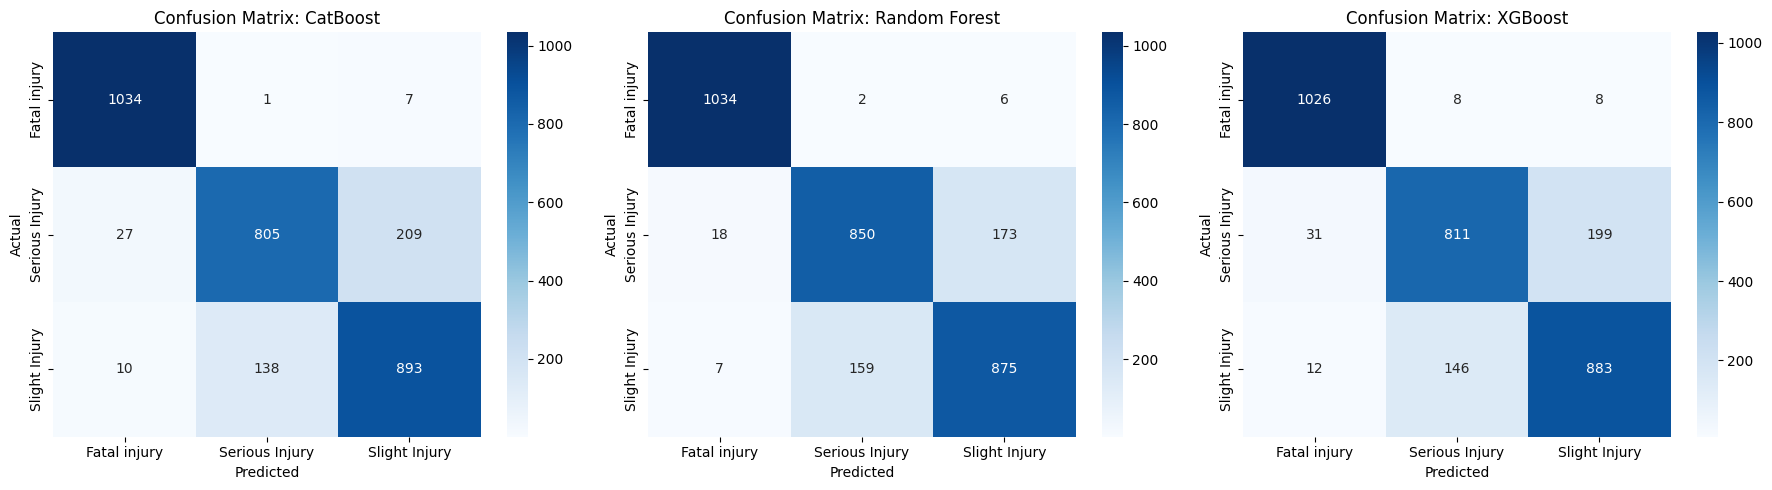


Text Summary of Confusion Matrix (CatBoost):
Actual Fatal injury, Predicted Fatal injury: 1034
Actual Fatal injury, Predicted Serious Injury: 1
Actual Fatal injury, Predicted Slight Injury: 7
Actual Serious Injury, Predicted Fatal injury: 27
Actual Serious Injury, Predicted Serious Injury: 805
Actual Serious Injury, Predicted Slight Injury: 209
Actual Slight Injury, Predicted Fatal injury: 10
Actual Slight Injury, Predicted Serious Injury: 138
Actual Slight Injury, Predicted Slight Injury: 893

Text Summary of Confusion Matrix (Random Forest):
Actual Fatal injury, Predicted Fatal injury: 1034
Actual Fatal injury, Predicted Serious Injury: 2
Actual Fatal injury, Predicted Slight Injury: 6
Actual Serious Injury, Predicted Fatal injury: 18
Actual Serious Injury, Predicted Serious Injury: 850
Actual Serious Injury, Predicted Slight Injury: 173
Actual Slight Injury, Predicted Fatal injury: 7
Actual Slight Injury, Predicted Serious Injury: 159
Actual Slight Injury, Predicted Slight Injury: 

In [27]:
# Import libraries
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Encode labels for XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize tuned models
catboost_model = CatBoostClassifier(depth=8, iterations=300, learning_rate=0.2, random_state=42, verbose=0)
rf_model = RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=300, random_state=42)
xgb_model = XGBClassifier(learning_rate=0.2, max_depth=9, n_estimators=200, random_state=42, eval_metric='mlogloss')

# Train models
catboost_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train_encoded)

# Predict on test set
y_pred_catboost = catboost_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_labels = label_encoder.inverse_transform(y_pred_xgb)

# Calculate metrics
metrics = {}
for model_name, y_pred in [("CatBoost", y_pred_catboost), ("Random Forest", y_pred_rf), ("XGBoost", y_pred_xgb_labels)]:
    metrics[model_name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted')
    }

# Get confusion matrices
cm_catboost = confusion_matrix(y_test, y_pred_catboost, labels=catboost_model.classes_)
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_model.classes_)
cm_xgb = confusion_matrix(y_test, y_pred_xgb_labels, labels=label_encoder.classes_)

# Display results
print("\nModel Comparison on Test Set (15 Features):")
for model_name, scores in metrics.items():
    print(f"\n{model_name}:")
    print(f"Accuracy: {scores['Accuracy']:.4f}")
    print(f"Precision: {scores['Precision']:.4f}")
    print(f"Recall: {scores['Recall']:.4f}")
    print(f"F1-Score: {scores['F1-Score']:.4f}")

print("\nConfusion Matrix (CatBoost):")
print(pd.DataFrame(cm_catboost, index=catboost_model.classes_, columns=catboost_model.classes_))

print("\nConfusion Matrix (Random Forest):")
print(pd.DataFrame(cm_rf, index=rf_model.classes_, columns=rf_model.classes_))

print("\nConfusion Matrix (XGBoost):")
print(pd.DataFrame(cm_xgb, index=label_encoder.classes_, columns=label_encoder.classes_))

# Visualize confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, cm, model_name in zip(axes, [cm_catboost, cm_rf, cm_xgb], ["CatBoost", "Random Forest", "XGBoost"]):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=ax)
    ax.set_title(f'Confusion Matrix: {model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# Text summary of confusion matrices
for model_name, cm in [("CatBoost", cm_catboost), ("Random Forest", cm_rf), ("XGBoost", cm_xgb)]:
    print(f"\nText Summary of Confusion Matrix ({model_name}):")
    for i, actual in enumerate(label_encoder.classes_):
        for j, predicted in enumerate(label_encoder.classes_):
            print(f"Actual {actual}, Predicted {predicted}: {cm[i, j]}")

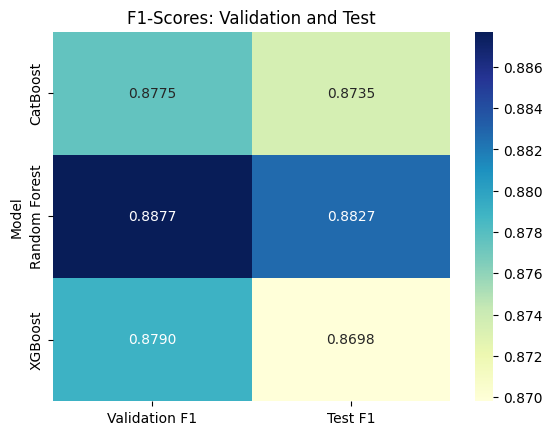

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "Model": ["CatBoost", "Random Forest", "XGBoost"],
    "Validation F1": [0.8775, 0.8877, 0.8790],
    "Test F1": [0.8735, 0.8827, 0.8698]
}).set_index("Model")

# Plot heatmap
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".4f")
plt.title("F1-Scores: Validation and Test")
plt.show()


In [29]:
# Import libraries
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load the preprocessed dataset
save_path = '/content/drive/MyDrive/Accident_Prediction_Preprocessed.csv'
df_preprocessed = pd.read_csv(save_path)

# Prepare features (X) and target (y)
X = df_preprocessed.drop('Accident_severity', axis=1)  # 15 features
y = df_preprocessed['Accident_severity']

# Split into 80% train and 20% remaining (test + validation), with stratification
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the 20% into 50% test and 50% validation, with stratification
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Verify split sizes
print("\nDataset Split Sizes:")
print(f"Training Set Size: {X_train.shape[0]} ({100 * X_train.shape[0] / X.shape[0]:.2f}%)")
print(f"Validation Set Size: {X_val.shape[0]} ({100 * X_val.shape[0] / X.shape[0]:.2f}%)")
print(f"Test Set Size: {X_test.shape[0]} ({100 * X_test.shape[0] / X.shape[0]:.2f}%)")

# Verify class distribution in each set
print("\nClass Distribution in Training Set (%):")
print(pd.Series(y_train).value_counts(normalize=True) * 100)
print("\nClass Distribution in Validation Set (%):")
print(pd.Series(y_val).value_counts(normalize=True) * 100)
print("\nClass Distribution in Test Set (%):")
print(pd.Series(y_test).value_counts(normalize=True) * 100)

# Verify number of features
print("\nNumber of Features in X_train:", X_train.shape[1])
print("Feature Names:", list(X_train.columns))


Dataset Split Sizes:
Training Set Size: 24996 (80.00%)
Validation Set Size: 3125 (10.00%)
Test Set Size: 3124 (10.00%)

Class Distribution in Training Set (%):
Accident_severity
Serious Injury    33.333333
Fatal injury      33.333333
Slight Injury     33.333333
Name: proportion, dtype: float64

Class Distribution in Validation Set (%):
Accident_severity
Serious Injury    33.344
Slight Injury     33.344
Fatal injury      33.312
Name: proportion, dtype: float64

Class Distribution in Test Set (%):
Accident_severity
Fatal injury      33.354673
Serious Injury    33.322663
Slight Injury     33.322663
Name: proportion, dtype: float64

Number of Features in X_train: 15
Feature Names: ['Number_of_casualties', 'Number_of_vehicles_involved', 'Day_of_week_Sunday', 'Types_of_Junction_No junction', 'Driving_experience', 'Light_conditions_Darkness - lights lit', 'Lanes_or_Medians_Undivided Two way', 'Road_allignment_Tangent road with flat terrain', 'Cause_of_accident_Moving Backward', 'Age_band_of_

In [30]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize and train tuned Random Forest model
tuned_rf = RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=300, random_state=42)
tuned_rf.fit(X_train, y_train)

# Predict on test set
y_pred_test = tuned_rf.predict(X_test)

# Calculate metrics
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

# Get confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test, labels=tuned_rf.classes_)

# Display results
print("\nTuned Random Forest Performance on Test Set (15 Features):")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")

print("\nConfusion Matrix (Test Set):")
print(cm_test)
print("\nConfusion Matrix (Labeled, Test Set):")
print(f"Classes: {tuned_rf.classes_}")
print(pd.DataFrame(cm_test, index=tuned_rf.classes_, columns=tuned_rf.classes_))

print("\nText Summary of Confusion Matrix (Test Set):")
for i, actual in enumerate(tuned_rf.classes_):
    for j, predicted in enumerate(tuned_rf.classes_):
        print(f"Actual {actual}, Predicted {predicted}: {cm_test[i, j]}")


Tuned Random Forest Performance on Test Set (15 Features):
Accuracy: 0.8832
Precision: 0.8825
Recall: 0.8832
F1-Score: 0.8827

Confusion Matrix (Test Set):
[[1034    2    6]
 [  18  850  173]
 [   7  159  875]]

Confusion Matrix (Labeled, Test Set):
Classes: ['Fatal injury' 'Serious Injury' 'Slight Injury']
                Fatal injury  Serious Injury  Slight Injury
Fatal injury            1034               2              6
Serious Injury            18             850            173
Slight Injury              7             159            875

Text Summary of Confusion Matrix (Test Set):
Actual Fatal injury, Predicted Fatal injury: 1034
Actual Fatal injury, Predicted Serious Injury: 2
Actual Fatal injury, Predicted Slight Injury: 6
Actual Serious Injury, Predicted Fatal injury: 18
Actual Serious Injury, Predicted Serious Injury: 850
Actual Serious Injury, Predicted Slight Injury: 173
Actual Slight Injury, Predicted Fatal injury: 7
Actual Slight Injury, Predicted Serious Injury: 159
Ac

In [31]:
# Import libraries
import shap
import numpy as np
import pandas as pd

# Verify input data
print("\nX_test Shape:", X_test.shape)
print("X_test Columns:", X_test.columns.tolist())
print("X_test Dtypes:\n", X_test.dtypes)
print("Classes:", tuned_rf.classes_)
print("Number of Classes:", len(tuned_rf.classes_))

# Ensure X_test is numeric
X_test_numeric = X_test.astype(float)
print("\nX_test_numeric Shape:", X_test_numeric.shape)
print("X_test_numeric Dtypes:\n", X_test_numeric.dtypes)

# Verify model output
print("\nModel Predict Proba Shape:", tuned_rf.predict_proba(X_test_numeric).shape)

# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(tuned_rf)

# Compute SHAP values with additivity check disabled
shap_values = explainer.shap_values(X_test_numeric, check_additivity=False)

# If shap_values is a numpy array, convert to list
if isinstance(shap_values, np.ndarray):
    print("\nConverting numpy array to list for multi-class compatibility")
    shap_values = [shap_values[:, :, i] for i in range(shap_values.shape[2])]

# Verify SHAP values
print("\nSHAP Values Type:", type(shap_values))
print("SHAP Values Length (Number of Classes):", len(shap_values))
print("Classes:", tuned_rf.classes_)
print("Expected Value (Base Value for Each Class):", explainer.expected_value)
for i, class_name in enumerate(tuned_rf.classes_):
    print(f"\nSHAP Values for Class {class_name} (Index {i}):")
    print(f"Shape: {np.array(shap_values[i]).shape}")


X_test Shape: (3124, 15)
X_test Columns: ['Number_of_casualties', 'Number_of_vehicles_involved', 'Day_of_week_Sunday', 'Types_of_Junction_No junction', 'Driving_experience', 'Light_conditions_Darkness - lights lit', 'Lanes_or_Medians_Undivided Two way', 'Road_allignment_Tangent road with flat terrain', 'Cause_of_accident_Moving Backward', 'Age_band_of_driver', 'Work_of_casuality_Driver', 'Sex_of_driver_Male', 'Area_accident_occured_Other', 'Age_band_of_casualty', 'Type_of_vehicle_Automobile']
X_test Dtypes:
 Number_of_casualties                              float64
Number_of_vehicles_involved                       float64
Day_of_week_Sunday                                   bool
Types_of_Junction_No junction                        bool
Driving_experience                                  int64
Light_conditions_Darkness - lights lit               bool
Lanes_or_Medians_Undivided Two way                   bool
Road_allignment_Tangent road with flat terrain       bool
Cause_of_accident_Mov

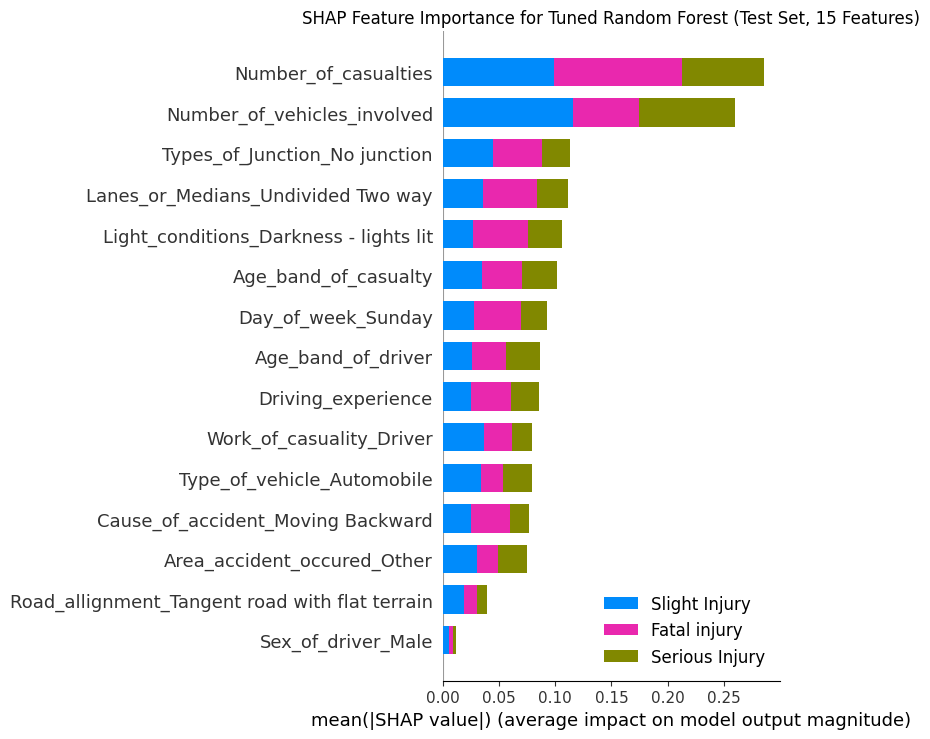


SHAP Feature Importance (Average Absolute Values):

Class: Fatal injury
                                           Feature  SHAP Value (Mean Abs)
0                             Number_of_casualties               0.113892
1                      Number_of_vehicles_involved               0.058496
5           Light_conditions_Darkness - lights lit               0.048767
6               Lanes_or_Medians_Undivided Two way               0.047751
3                    Types_of_Junction_No junction               0.043143
2                               Day_of_week_Sunday               0.041073
13                            Age_band_of_casualty               0.035367
8                Cause_of_accident_Moving Backward               0.034792
4                               Driving_experience               0.034764
9                               Age_band_of_driver               0.030203
10                        Work_of_casuality_Driver               0.024548
14                      Type_of_vehicle

In [32]:
# Import libraries
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Generate SHAP summary plot (bar)
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=tuned_rf.classes_, show=False)
plt.title("SHAP Feature Importance for Tuned Random Forest (Test Set, 15 Features)")
plt.tight_layout()
plt.savefig("shap_summary_bar.png")
plt.show()

# Compute and display mean absolute SHAP values per class
print("\nSHAP Feature Importance (Average Absolute Values):")
for i, class_name in enumerate(tuned_rf.classes_):
    print(f"\nClass: {class_name}")
    shap_df = pd.DataFrame({
        "Feature": X_test.columns,
        "SHAP Value (Mean Abs)": np.abs(shap_values[i]).mean(axis=0)
    }).sort_values(by="SHAP Value (Mean Abs)", ascending=False)
    print(shap_df)

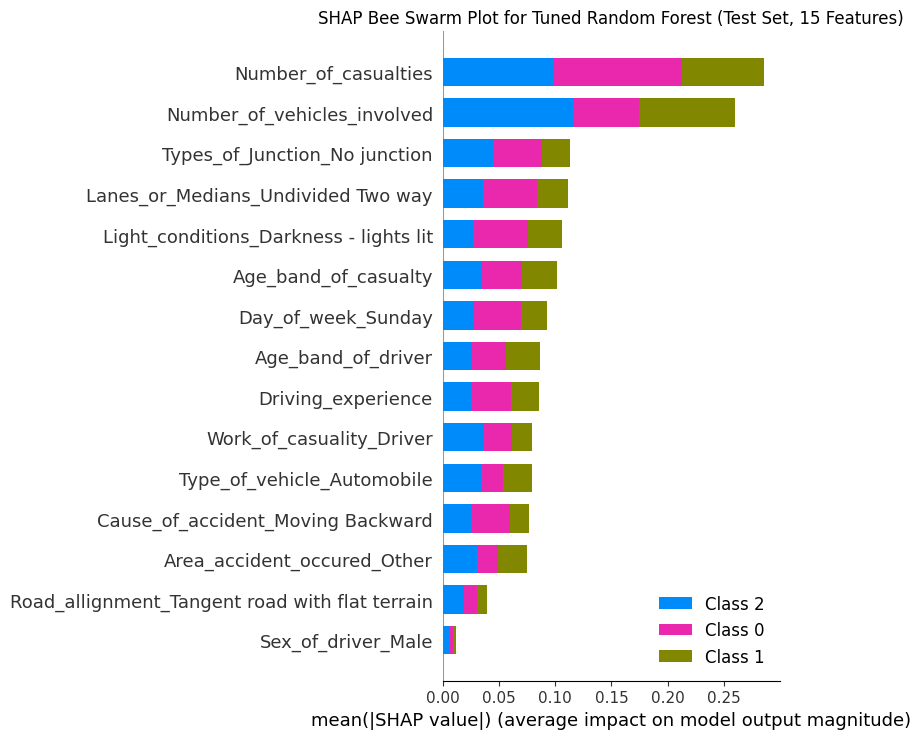


Textual Summary of SHAP Bee Swarm Plot (Top 3 Features per Class):

Class: Fatal injury
                                  Feature  Mean Absolute SHAP Value
0                    Number_of_casualties                  0.113892
1             Number_of_vehicles_involved                  0.058496
2  Light_conditions_Darkness - lights lit                  0.048767

Class: Serious Injury
                       Feature  Mean Absolute SHAP Value
0  Number_of_vehicles_involved                  0.085198
1         Number_of_casualties                  0.072792
2         Age_band_of_casualty                  0.031117

Class: Slight Injury
                         Feature  Mean Absolute SHAP Value
0    Number_of_vehicles_involved                  0.116049
1           Number_of_casualties                  0.098940
2  Types_of_Junction_No junction                  0.044807


In [33]:
# Import libraries
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Generate SHAP bee swarm plot
plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Bee Swarm Plot for Tuned Random Forest (Test Set, 15 Features)")
plt.tight_layout()
plt.savefig("shap_bee_swarm.png")
plt.show()

# Compute textual summary: top 3 features per class based on mean absolute SHAP values
print("\nTextual Summary of SHAP Bee Swarm Plot (Top 3 Features per Class):")
for i, class_name in enumerate(tuned_rf.classes_):
    mean_abs_shap = np.abs(shap_values[i]).mean(axis=0)
    top_features_idx = np.argsort(mean_abs_shap)[::-1][:3]
    top_features = pd.DataFrame({
        "Feature": X_test.columns[top_features_idx],
        "Mean Absolute SHAP Value": mean_abs_shap[top_features_idx]
    })
    print(f"\nClass: {class_name}")
    print(top_features)

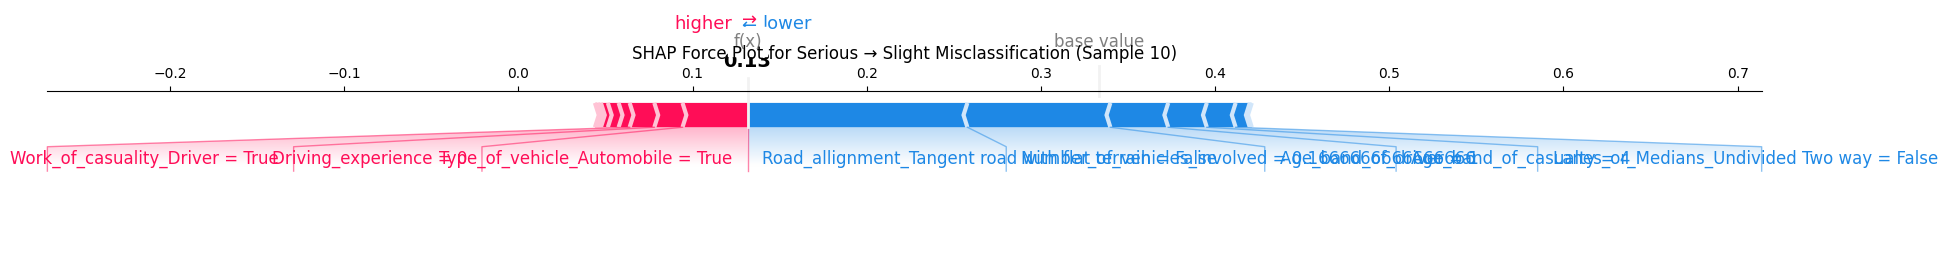


Local Explanation for Serious → Slight Misclassification (Sample 10):
                                                                                       Feature  \
Road_allignment_Tangent road with flat terrain  Road_allignment_Tangent road with flat terrain   
Number_of_vehicles_involved                                        Number_of_vehicles_involved   
Type_of_vehicle_Automobile                                          Type_of_vehicle_Automobile   
Age_band_of_driver                                                          Age_band_of_driver   
Age_band_of_casualty                                                      Age_band_of_casualty   
Lanes_or_Medians_Undivided Two way                          Lanes_or_Medians_Undivided Two way   
Driving_experience                                                          Driving_experience   
Work_of_casuality_Driver                                              Work_of_casuality_Driver   
Area_accident_occured_Other                    

In [34]:
# Import libraries
import shap
import numpy as np
import pandas as pd

# Identify a Serious → Slight misclassification
y_test_array = y_test.to_numpy()
y_pred_test = tuned_rf.predict(X_test)
misclassified_indices = np.where((y_test_array == 'Serious Injury') & (y_pred_test == 'Slight Injury'))[0]

if len(misclassified_indices) > 0:
    sample_idx = misclassified_indices[0]  # Take the first misclassified sample
    sample_data = X_test.iloc[sample_idx:sample_idx + 1]
    shap_values_sample = [sv[sample_idx:sample_idx + 1] for sv in shap_values]

    # Generate SHAP force plot for the misclassified sample
    explainer = shap.TreeExplainer(tuned_rf)
    shap.force_plot(explainer.expected_value[1],  # Base value for Serious Injury
                    shap_values_sample[1],  # SHAP values for Serious Injury
                    sample_data,
                    matplotlib=True,
                    show=False)
    plt.title(f"SHAP Force Plot for Serious → Slight Misclassification (Sample {sample_idx})")
    plt.tight_layout()
    plt.savefig(f"shap_force_plot_sample_{sample_idx}.png")
    plt.show()

    # Print feature contributions
    print(f"\nLocal Explanation for Serious → Slight Misclassification (Sample {sample_idx}):")
    feature_contribs = pd.DataFrame({
        "Feature": sample_data.columns,
        "Value": sample_data.iloc[0],
        "SHAP Value": shap_values_sample[1][0]
    }).sort_values(by="SHAP Value", key=abs, ascending=False)
    print(feature_contribs)
else:
    print("\nNo Serious → Slight misclassifications found in the test set.")